УЛУЧШЕННАЯ КЛАСТЕРИЗАЦИЯ SMS СООБЩЕНИЙ
Загрузка данных SMS Spam Collection...
Загружено 5574 сообщений

АНАЛИЗ ХАРАКТЕРИСТИК СООБЩЕНИЙ

--- HAM сообщения ---
Количество: 4827
Средняя длина: 71.4 символов
Среднее количество слов: 14.3
Среднее количество цифр: 0.3
Содержат URL: 17 (0.4%)
Содержат номера телефонов: 1 (0.0%)
Содержат валюту: 19 (0.4%)

--- SPAM сообщения ---
Количество: 747
Средняя длина: 138.6 символов
Среднее количество слов: 23.9
Среднее количество цифр: 15.8
Содержат URL: 121 (16.2%)
Содержат номера телефонов: 378 (50.6%)
Содержат валюту: 257 (34.4%)


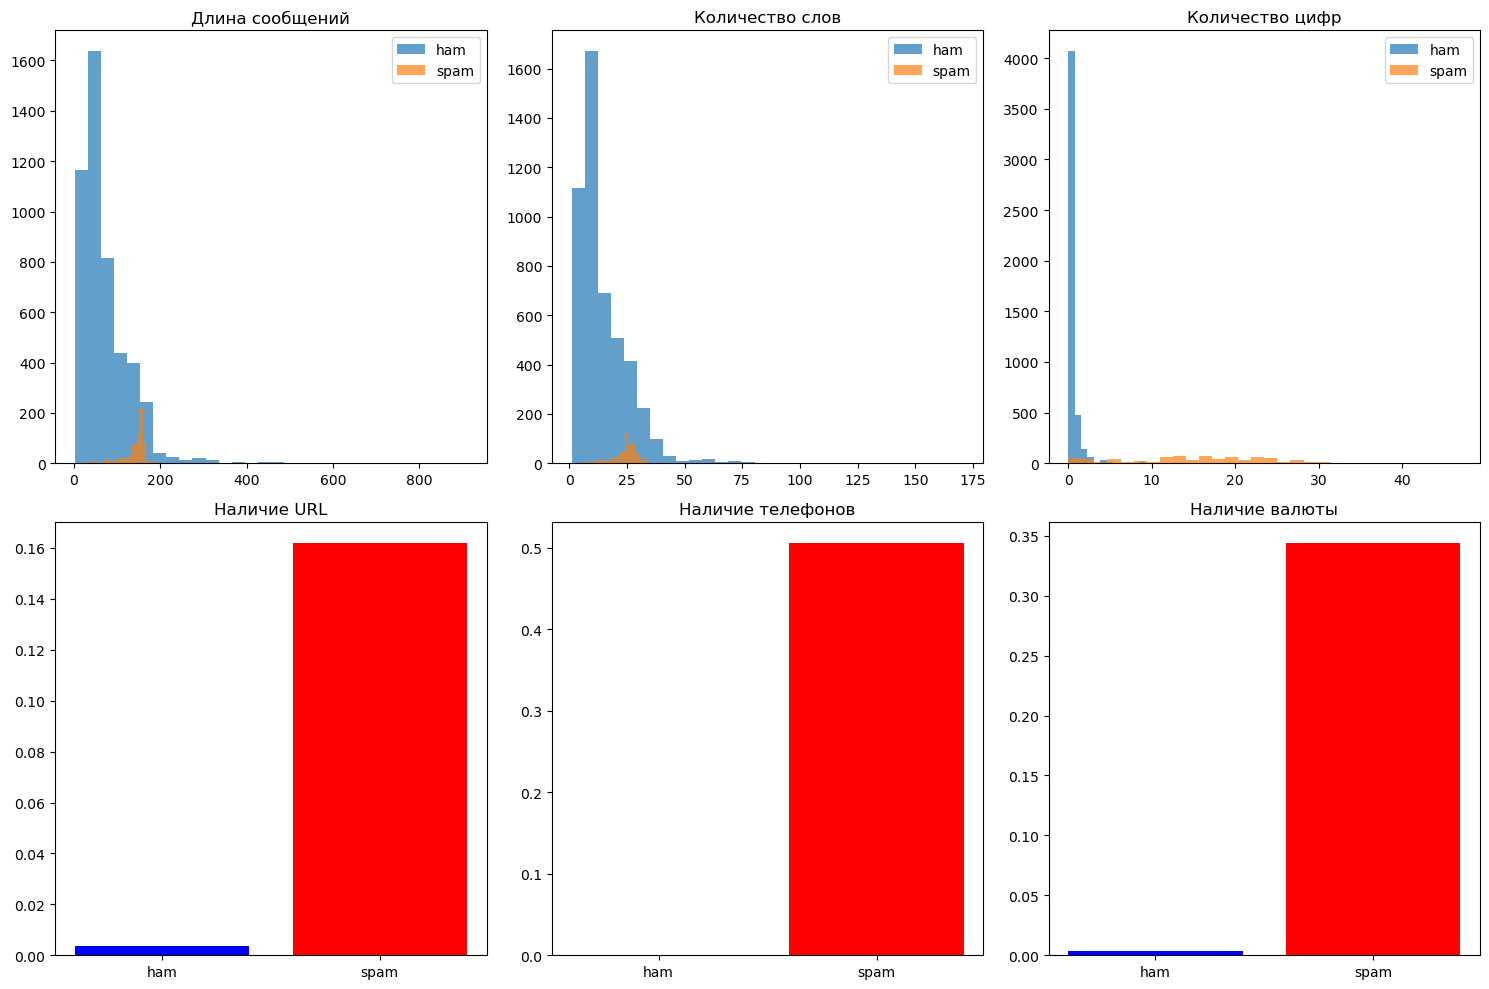

Создано 307 комбинированных признаков

Финальная размерность данных: (5574, 307)

K-MEANS КЛАСТЕРИЗАЦИЯ

K-Means Результаты:
Оптимальное число кластеров: 2
Silhouette Score: 0.161
Calinski-Harabasz Score: 97.072
Davies-Bouldin Score: 5.137


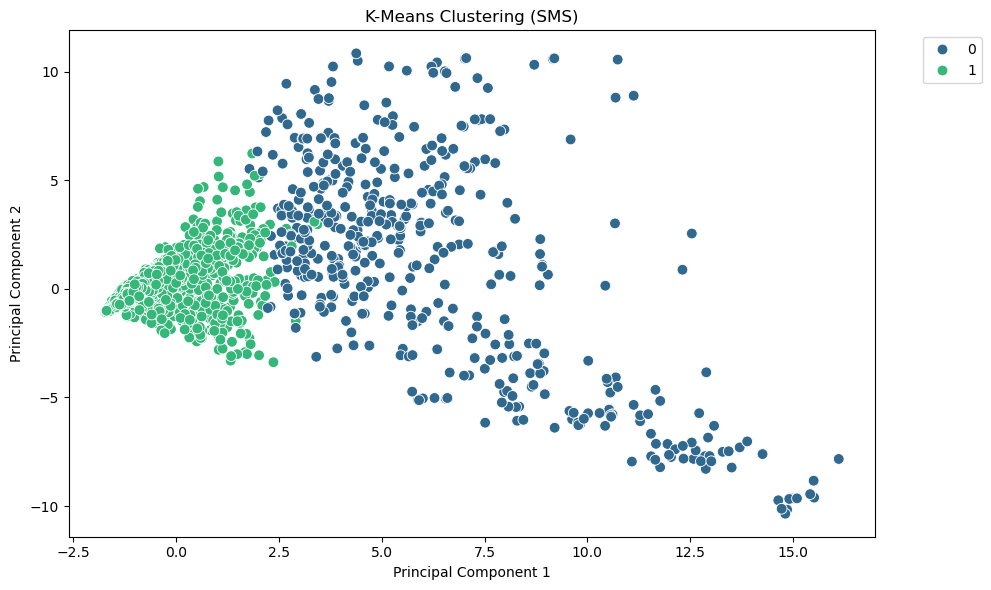


ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ

Иерархическая кластеризация:
Оптимальное число кластеров: 2
Silhouette Score: 0.221
Calinski-Harabasz Score: 70.947
Davies-Bouldin Score: 3.389


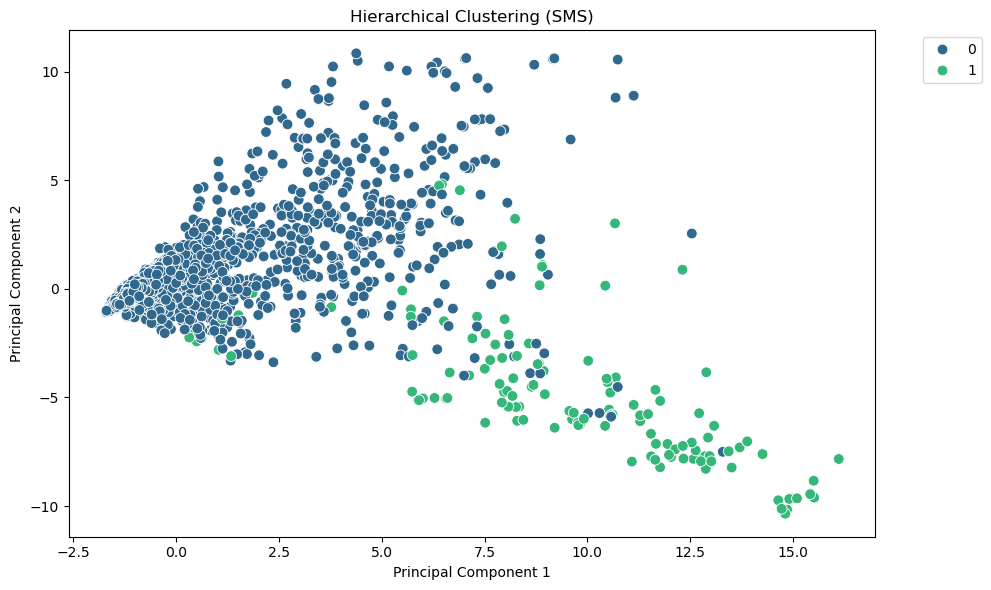


DBSCAN КЛАСТЕРИЗАЦИЯ

DBSCAN Результаты:
Лучшие параметры: eps=1.00, min_samples=2
Silhouette Score: 0.061
Calinski-Harabasz Score: 4.329
Davies-Bouldin Score: 1.083
Число кластеров: 498
Выбросы: 3535


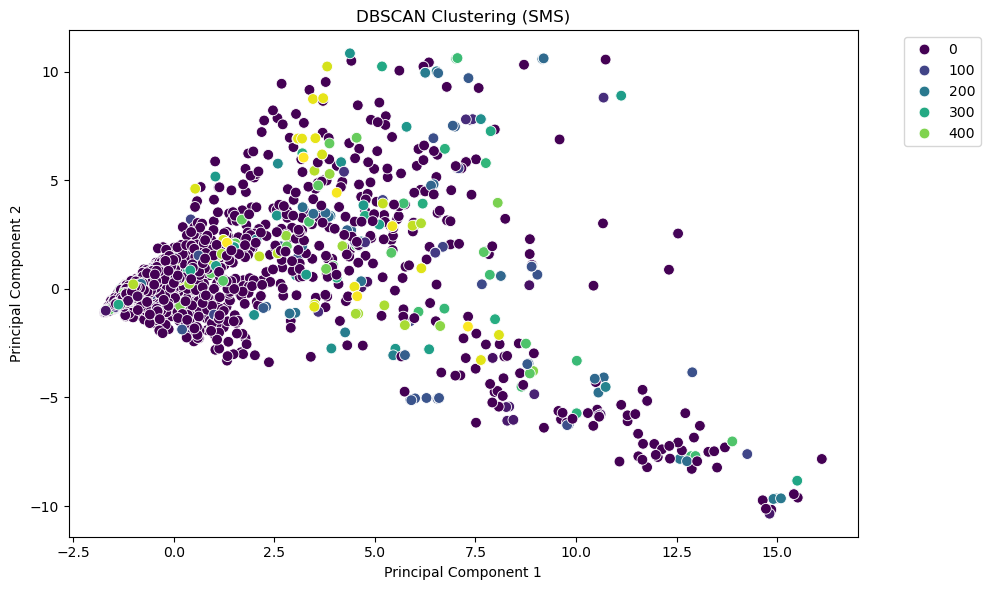

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
import re
import warnings
import os

# Игнорирование предупреждений
warnings.filterwarnings("ignore")
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

class TextFeatureExtractor(BaseEstimator, TransformerMixin):
    """Извлечение признаков из текста сообщений"""
    
    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=300, stop_words='english', 
                                         min_df=2, max_df=0.85)
    
    def fit(self, X, y=None):
        texts = [self.preprocess_text(msg) for msg in X]
        self.vectorizer.fit(texts)
        return self
    
    def transform(self, X):
        texts = [self.preprocess_text(msg) for msg in X]
        return self.vectorizer.transform(texts).toarray()
    
    def preprocess_text(self, text):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

class MetadataFeatureExtractor(BaseEstimator, TransformerMixin):
    """Извлечение мета-признаков из сообщений"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = []
        for text in X:
            if not isinstance(text, str):
                features.append([0, 0, 0, 0, 0, 0, 0])
                continue
                
            # Длина сообщения
            length = len(text)
            
            # Количество цифр (важно для спама)
            digits = len(re.findall(r'\d', text))
            
            # Количество специальных символов (£, $, !)
            special_chars = len(re.findall(r'[£$!]', text))
            
            # Количество слов
            words = len(text.split())
            
            # Наличие ключевых слов спама
            spam_keywords = len(re.findall(r'\b(free|win|prize|cash|claim|call now|urgent|winner|guaranteed)\b', text.lower()))
            
            # Наличие URL
            has_url = 1 if re.search(r'http|www|\.com|\.co\.uk', text.lower()) else 0
            
            # Наличие номеров телефонов
            has_phone = 1 if re.search(r'\b\d{10,13}\b', text) else 0
            
            features.append([length, digits, special_chars, words, spam_keywords, has_url, has_phone])
        
        return np.array(features)

def load_sms_data_enhanced():
    """Улучшенная загрузка с использованием всех данных"""
    try:
        print("Загрузка данных SMS Spam Collection...")
        data = []
        with open('SMSSpamCollection.txt', 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    data.append(parts)
        
        # Создание DataFrame
        df = pd.DataFrame(data, columns=['label', 'message'])
        
        # Преобразование меток
        df['target'] = df['label'].map({'ham': 0, 'spam': 1})
        
        print(f"Загружено {len(df)} сообщений")
        
        # Анализ характеристик данных
        analyze_message_characteristics(df)
        
        # Создание комбинированных признаков
        feature_union = FeatureUnion([
            ('text_features', TextFeatureExtractor()),
            ('meta_features', MetadataFeatureExtractor())
        ])
        
        X_combined = feature_union.fit_transform(df['message'])
        
        # Масштабирование
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_combined)
        
        print(f"Создано {X_scaled.shape[1]} комбинированных признаков")
        
        return X_scaled, df['target'].values, df['label'].values, df['message'].values
    
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return None, None, None, None

def analyze_message_characteristics(df):
    """Анализ характеристик сообщений"""
    print("\n" + "="*50)
    print("АНАЛИЗ ХАРАКТЕРИСТИК СООБЩЕНИЙ")
    print("="*50)
    
    # Статистика по длине сообщений
    df['message_length'] = df['message'].apply(lambda x: len(str(x)))
    df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))
    df['digit_count'] = df['message'].apply(lambda x: len(re.findall(r'\d', str(x))))
    df['has_url'] = df['message'].apply(lambda x: 1 if re.search(r'http|www|\.com', str(x).lower()) else 0)
    df['has_phone'] = df['message'].apply(lambda x: 1 if re.search(r'\b\d{10,13}\b', str(x)) else 0)
    df['has_currency'] = df['message'].apply(lambda x: 1 if re.search(r'[£$]', str(x)) else 0)
    
    # Статистика по классам
    for label in ['ham', 'spam']:
        subset = df[df['label'] == label]
        print(f"\n--- {label.upper()} сообщения ---")
        print(f"Количество: {len(subset)}")
        print(f"Средняя длина: {subset['message_length'].mean():.1f} символов")
        print(f"Среднее количество слов: {subset['word_count'].mean():.1f}")
        print(f"Среднее количество цифр: {subset['digit_count'].mean():.1f}")
        print(f"Содержат URL: {subset['has_url'].sum()} ({subset['has_url'].mean()*100:.1f}%)")
        print(f"Содержат номера телефонов: {subset['has_phone'].sum()} ({subset['has_phone'].mean()*100:.1f}%)")
        print(f"Содержат валюту: {subset['has_currency'].sum()} ({subset['has_currency'].mean()*100:.1f}%)")
    
    # Визуализация характеристик
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Длина сообщений
    for label in ['ham', 'spam']:
        subset = df[df['label'] == label]
        axes[0,0].hist(subset['message_length'], alpha=0.7, label=label, bins=30)
    axes[0,0].set_title('Длина сообщений')
    axes[0,0].legend()
    
    # Количество слов
    for label in ['ham', 'spam']:
        subset = df[df['label'] == label]
        axes[0,1].hist(subset['word_count'], alpha=0.7, label=label, bins=30)
    axes[0,1].set_title('Количество слов')
    axes[0,1].legend()
    
    # Количество цифр
    for label in ['ham', 'spam']:
        subset = df[df['label'] == label]
        axes[0,2].hist(subset['digit_count'], alpha=0.7, label=label, bins=30)
    axes[0,2].set_title('Количество цифр')
    axes[0,2].legend()
    
    # Наличие URL
    url_stats = df.groupby('label')['has_url'].mean()
    axes[1,0].bar(url_stats.index, url_stats.values, color=['blue', 'red'])
    axes[1,0].set_title('Наличие URL')
    
    # Наличие телефонов
    phone_stats = df.groupby('label')['has_phone'].mean()
    axes[1,1].bar(phone_stats.index, phone_stats.values, color=['blue', 'red'])
    axes[1,1].set_title('Наличие телефонов')
    
    # Наличие валюты
    currency_stats = df.groupby('label')['has_currency'].mean()
    axes[1,2].bar(currency_stats.index, currency_stats.values, color=['blue', 'red'])
    axes[1,2].set_title('Наличие валюты')
    
    plt.tight_layout()
    plt.show()


def main_enhanced():
    """Улучшенная основная функция"""
    print("="*60)
    print("УЛУЧШЕННАЯ КЛАСТЕРИЗАЦИЯ SMS СООБЩЕНИЙ")
    print("="*60)
    
    X, y, original_labels, messages = load_sms_data_enhanced()
    if X is None:
        return
    
    print(f"\nФинальная размерность данных: {X.shape}")
    
    # Применение алгоритмов кластеризации
    print("\n" + "="*40)
    print("K-MEANS КЛАСТЕРИЗАЦИЯ")
    print("="*40)
    apply_kmeans(X)
    
    print("\n" + "="*40)
    print("ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ")
    print("="*40)
    apply_hierarchical(X)
    
    print("\n" + "="*40)
    print("DBSCAN КЛАСТЕРИЗАЦИЯ")
    print("="*40)
    apply_dbscan(X)

if __name__ == "__main__":
    main_enhanced()